In [1]:
import cv2
import numpy as np

import matplotlib.pyplot as plt

In [2]:
def RYB_filters(image):

    nemo = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    hsv_nemo = cv2.cvtColor(nemo, cv2.COLOR_RGB2HSV)
    light_red1 =(0, 50, 20)
    dark_red1 = (10, 255, 255)
    
    light_red2 =(160, 45, 20)
    dark_red2 = (180, 255, 255)


    light_white = (0, 0, 200)
    dark_white = (145, 60, 255)

    light_blue = (100,100,0)
    dark_blue = (140,255,255)

    light_yellow = (10,  100, 20)
    dark_yellow = (36, 255, 255)
    
    # Denoising the images
    kernel = np.ones((2,2),np.float32)/4
    
    

    red1_mask = cv2.inRange(hsv_nemo, light_red1, dark_red1)
    red2_mask = cv2.inRange(hsv_nemo, light_red2, dark_red2)
    white_mask = cv2.inRange(hsv_nemo, light_white, dark_white)
    blue_mask = cv2.inRange(hsv_nemo, light_blue, dark_blue)
    yellow_mask = cv2.inRange(hsv_nemo, light_yellow, dark_yellow)

    #filt_mask = cv2.GaussianBlur(white_mask, (3,3),0)
    #filt_mask = cv2.medianBlur(blue_mask,3)    



    plt.show()
    mask_list = [red1_mask, red2_mask, blue_mask, yellow_mask, white_mask]
    return mask_list

In [3]:
def is_contour_good(c):
    # approximate the contour
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)
    # the contour is 'bad' if it is not a rectangle
    return peri > 25

# contour filter for r2 should be differen we should filter less
def is_contour_good_r2(c):
    # approximate the contour
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)
    # the contour is 'bad' if it is not a rectangle
    return peri > 10

In [4]:
def cont_filter_draw_box(image,mask_list):  #### will filter only perimeter not Area #########
    # contains filtered contours
    filtered_masks = []
    bounding_boxes = []
    contours_poly = []
    count = 1
    for i in mask_list:
        ret,thresh = cv2.threshold(i,127,255,cv2.THRESH_BINARY)
        cnts, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
        mask = np.ones(image.shape[:2], dtype="uint8") * 255
        
        # Approximate contours to polygons + get bounding rects and circles
        contours_poly = [None]*len(cnts)
        boundRect = [None]*len(cnts)
        #centers = [None]*len(cnts)
        #radius = [None]*len(cnts)
        # loop over the contours
        count = 1
        for i, c in enumerate(cnts):
            # if the contour is good, draw it on the mask (For filtering)
            if count ==2 or count == 3 :
                if is_contour_good_r2:
                    cv2.drawContours(mask, [c], -1, 0, -1)
                    contours_poly[i] = cv2.approxPolyDP(c, 3, True)
                    boundRect[i] = cv2.boundingRect(contours_poly[i])
                    #centers[i], radius[i] = cv2.minEnclosingCircle(contours_poly[i])
            else:
                if is_contour_good:
                    cv2.drawContours(mask, [c], -1, 0, -1)
                    contours_poly[i] = cv2.approxPolyDP(c, 3, True)
                    boundRect[i] = cv2.boundingRect(contours_poly[i])
                    #centers[i], radius[i] = cv2.minEnclosingCircle(contours_poly[i])     
        count+=1
        # remove the contours from the image and show the resulting images
        # image = cv2.bitwise_and(image, image, mask=mask)
        filtered_masks.append(mask)
        bounding_boxes.append(boundRect)
        contours_poly.append(contours_poly[i])
    return filtered_masks, bounding_boxes, cnts

In [5]:
def display(path):
    image = cv2.imread(path)
    # filter the R(r1,r2) B Y and W colours 
    # mask_list = [red1_mask, red2_mask, blue_mask, yellow_mask ,white_mask]
    mask_list = RYB_filters(image)
    filtered_masks, bounding_boxes, cnts = cont_filter_draw_box(image, mask_list)
    plt.figure(figsize = (30,30))
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    bound_image = np.copy(rgb_image)
    ALL_foltered_b_boxes = []
    color1 = (0, 255,0)
    c_list = [(255,0,0), (200,0,0), (0,0,255),(255,255,0),(0,0,0) ]
    for k in range(len(bounding_boxes)):
        boundRect  = bounding_boxes[k]
        color = c_list[k]
        for j in range(len(boundRect)):
            
            area_of_rec = int(boundRect[j][2]) * int(boundRect[j][3])
            h = int(boundRect[j][2])
            w = int(boundRect[j][3])
            if(area_of_rec >= 350 and w<=4*h and h<=4*w) :
                           cv2.rectangle(bound_image, (int(boundRect[j][0]), int(boundRect[j][1])),(int(boundRect[j][0]+boundRect[j][2]), int(boundRect[j][1]+boundRect[j][3])), color, 2)
                           ALL_foltered_b_boxes.append(boundRect[j])
                #cv2.circle(drawing, (int(centers[i][0]), int(centers[i][1])), int(radius[i]), color, 2)
                #cv2.circle(drawing, (int(centers[i][0]), int(centers[i][1])), int(radius[i]), color, 2)
    print(len(ALL_foltered_b_boxes))
    
    i = 1
    plt.subplot(6, 2, i)
    plt.title("Original")
    plt.imshow(rgb_image)
    #cv2.imwrite('rp_img/'+'result'+'.png',cv2.cvtColor(bound_image, cv2.COLOR_RGB2BGR))
    i = 2
    plt.subplot(6, 2, i)
    plt.title("All Boxes")
    plt.imshow(bound_image, cmap="gray")
    

    name = ['red1_mask', 'red2_mask', 'blue_mask', 'yellow_mask' ,'white_mask']
    for i in range((len(mask_list))*2):
        color = c_list[i//2]
        empt = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)+255
        img = rgb_image
        plt.subplot(6,2, i+3)
        if i%2==0:
            plt.title(name[i//2])
            plt.imshow(mask_list[i//2], cmap='gray')
            #cv2.imwrite('rp_img/'+str(name[i//2])+'.png',mask_list[i//2])
        else:
            boundRect  = bounding_boxes[i//2]
            for j in range(len(boundRect)):
                area_of_rec = int(boundRect[j][2]) * int(boundRect[j][3])
                h = int(boundRect[j][2])
                w = int(boundRect[j][3])
                if(area_of_rec >= 350 and w<=4*h and h<=4*w) :
                    cv2.rectangle(empt, (int(boundRect[j][0]), int(boundRect[j][1])),(int(boundRect[j][0]+boundRect[j][2]), int(boundRect[j][1]+boundRect[j][3])), color, 3)
                    #cv2.circle(drawing, (int(centers[i][0]), int(centers[i][1])), int(radius[i]), color, 2)
                    #cv2.circle(drawing, (int(centers[i][0]), int(centers[i][1])), int(radius[i]), color, 2)
            plt.title(name[i//2]+'Boxes')
            plt.imshow(empt)
            cv2.imwrite('rp_img/'+str(name[i//2])+' Boxes'+'.png',cv2.cvtColor(empt, cv2.COLOR_RGB2BGR))
            

In [6]:
def new_ss(image):
    # input is BRG image can read directly using cv2 and pass though this
    mask_list = RYB_filters(image)
    filtered_masks, bounding_boxes, cnts = cont_filter_draw_box(image, mask_list)
    plt.figure(figsize = (30,30))
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    bound_image = np.copy(rgb_image)
    All_filtered_b_boxes = []
    color1 = (0, 255,0)
    count = 0
    for k in range(len(bounding_boxes)):
        boundRect  = bounding_boxes[k]
        for j in range(len(boundRect)):
            area_of_rec = int(boundRect[j][2]) * int(boundRect[j][3])
            h = int(boundRect[j][2])
            w = int(boundRect[j][3])
            if(area_of_rec >= 400 and w<=4*h and h<=4*w) :
                           count+=1
                           cv2.rectangle(bound_image, (int(boundRect[j][0]), int(boundRect[j][1])),(int(boundRect[j][0]+boundRect[j][2]), int(boundRect[j][1]+boundRect[j][3])), color1, 2)
                           All_filtered_b_boxes.append(boundRect[j])
                #cv2.circle(drawing, (int(centers[i][0]), int(centers[i][1])), int(radius[i]), color, 2)
                #cv2.circle(drawing, (int(centers[i][0]), int(centers[i][1])), int(radius[i]), color, 2)
    # Return the list of all bounding boxes and image with bounding boxes
    print(count)
    return All_filtered_b_boxes , bound_image, count

<Figure size 1440x1440 with 0 Axes>

34


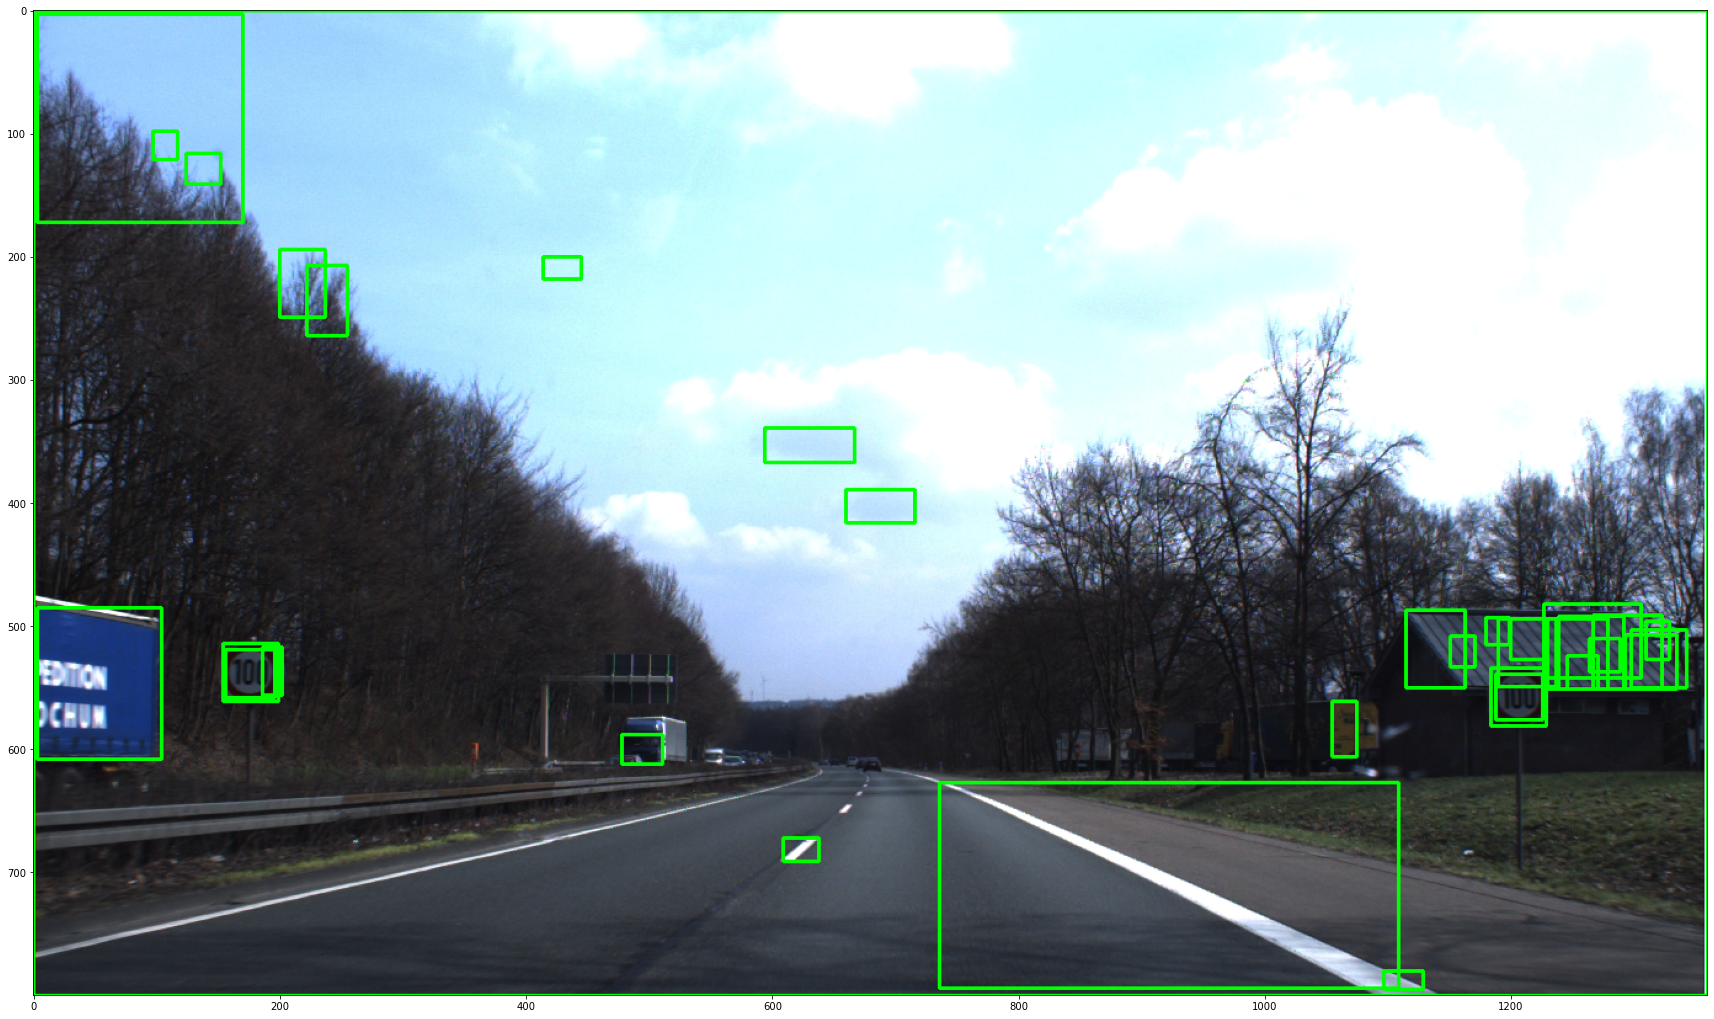

In [17]:
# test new_ss
plt.figure(figsize=(20,20))
img = cv2.imread('TrainIJCNN2013/00483.ppm')
a , im , c= new_ss(img)
plt.imshow(im)



41


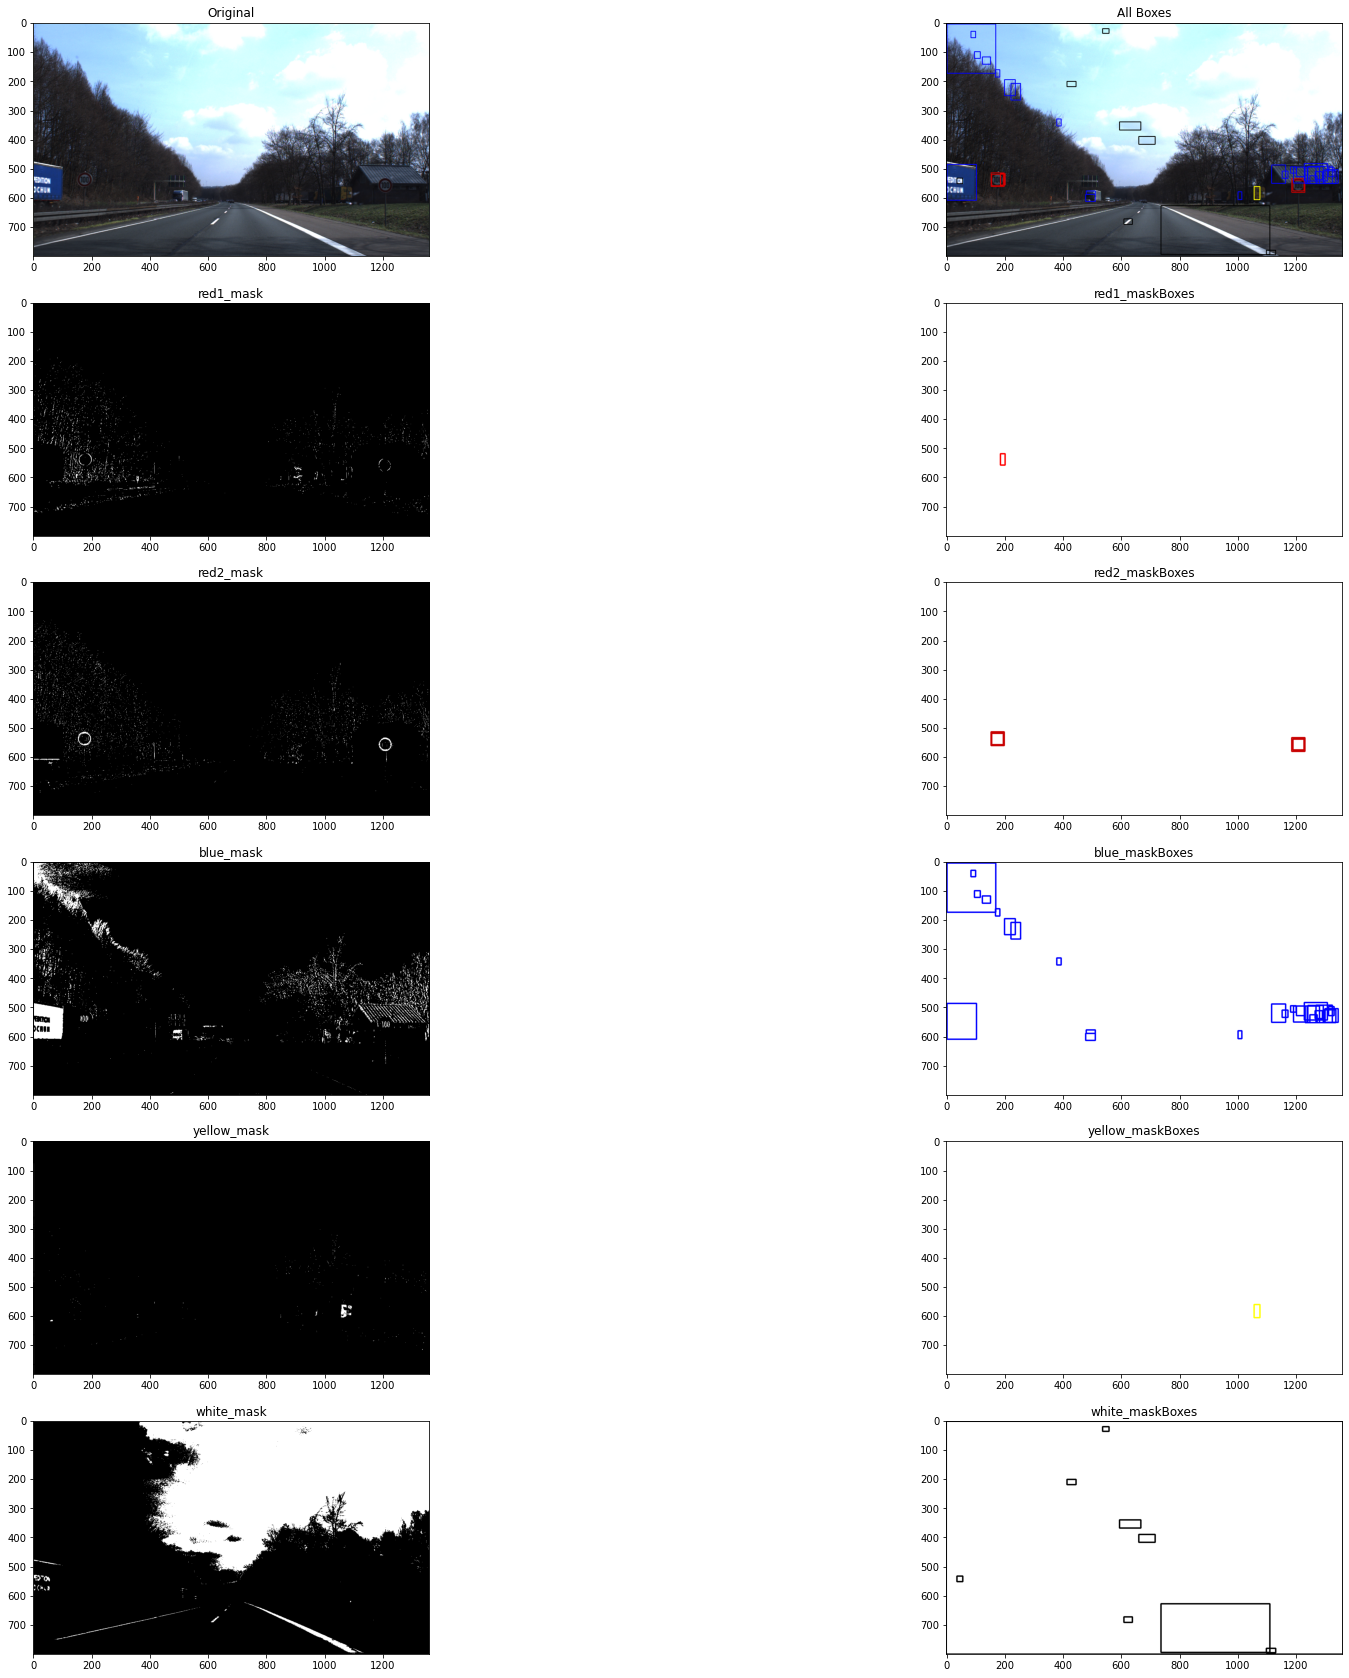

In [12]:
display('TrainIJCNN2013/00483.ppm')